In [1]:
# Core
import numpy as np
import pandas as pd

# Tensorflow / ML
import tensorflow as tf

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Utility
import time

In [2]:
# Configure TF GPU growth
import kepler_sieve
from tf_utils import gpu_grow_memory
gpu_grow_memory(verbose=True)

Found 4 GPUs.  Setting memory growth = True.


In [3]:
# MSE Imports
from asteroid_element import load_ast_elt
from candidate_element import asteroid_elts, perturb_elts, random_elts, elts_add_mixture_params, elts_add_H
from ztf_ast import load_ztf_nearest_ast, calc_hit_freq
from ztf_element import load_ztf_batch, make_ztf_batch, ztf_score_by_elt, ztf_elt_summary
from asteroid_model import AsteroidPosition, AsteroidDirection, make_model_ast_pos
from asteroid_search_layers import CandidateElements, MixtureParameters, TrajectoryScore
from asteroid_search_model import AsteroidSearchModel, make_opt_adam
from asteroid_search_report import traj_diff
from nearest_asteroid import nearest_ast_elt_cart, nearest_ast_elt_cov, elt_q_norm
from element_eda import score_by_elt
from asteroid_dataframe import calc_ast_data, spline_ast_vec_df
from astro_utils import deg2dist, dist2deg, dist2sec

In [4]:
# Aliases
keras = tf.keras

# Constants
dtype = tf.float32
dtype_np = np.float32
space_dims = 3

In [5]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

## Load ZTF Data and Batch of Orbital Elements

In [6]:
# Load orbital elements for known asteroids
ast_elt = load_ast_elt()

# Number of asteroids
N_ast = ast_elt.shape[0]

In [7]:
# Load ztf nearest asteroid data
ztf_ast = load_ztf_nearest_ast()

In [8]:
# Asteroid numbers and hit counts
ast_num, hit_count = calc_hit_freq(ztf=ztf_ast, thresh_sec=2.0)

# Sort the hit counts in descending order and find the top batch_size
idx = np.argsort(hit_count)[::-1]

# Extract the asteroid number and hit count for this batch
ast_num_best = ast_num[idx]
hit_count_best = hit_count[idx]

In [9]:
# Parameters to build elements batch
batch_size = 64

# Batch of unperturbed elements
elts_ast = asteroid_elts(ast_nums=ast_num_best[0:batch_size])

In [10]:
# # Review unperturbed elements
# elts_ast

In [11]:
# Inputs to perturb elements: large
sigma_a = 0.05
sigma_e = 0.01
sigma_inc_deg = 0.25
sigma_f_deg = 1.0
sigma_Omega_deg = 1.0
sigma_omega_deg = 1.0
mask_pert = None
random_seed = 42

In [12]:
# Inputs to perturb elements: small
sigma_a = 0.01
sigma_e = 0.0025
sigma_inc_deg = 0.05
sigma_f_deg = 0.25
sigma_Omega_deg = 0.25
sigma_omega_deg = 0.25
mask_pert = None
random_seed = 42

In [13]:
# Perturb orbital elements
elts_pert= perturb_elts(elts_ast, sigma_a=sigma_a, sigma_e=sigma_e, 
                    sigma_inc_deg=sigma_inc_deg, sigma_f_deg=sigma_f_deg, 
                    sigma_Omega_deg=sigma_Omega_deg, sigma_omega_deg=sigma_omega_deg,
                    mask_pert=mask_pert, random_seed=random_seed)

In [14]:
# Choose which elements to search on
elts = elts_pert

In [15]:
# # Search for nearest asteroids to these elements
# elts_near = nearest_ast_elt(elts)

In [16]:
# Review selected initial candidate elements, including the nearest asteroid information
# elts

In [17]:
# Review nearest asteroid to these candidate elements
# elts_near

In [18]:
# How many elements are still closest to the original elements?
# np.sum(elts.nearest_ast_num == elts.element_id)

## Batches of ZTF Data Near Initial Candidate Elements

In [19]:
# Arguments to make_ztf_batch
thresh_deg = 2.0
near_ast = False
regenerate = False

In [20]:
# Load perturbed element batch
ztf_elt = load_ztf_batch(elts=elts, thresh_deg=thresh_deg, near_ast=near_ast, regenerate=regenerate)

In [21]:
# Review ZTF elements
ztf_elt

,ztf_id,element_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,mag_app,ux,...,vz,elt_ux,elt_uy,elt_uz,elt_r,s,s_sec,z,v,is_hit
0,53851,733,b'ZTF18abnothj',594197584815010004,5501,58348.197581,266.229165,-13.513802,16.755600,-0.063945,...,0.004058,-0.041592,-0.981941,0.184561,2.234762,0.025900,5342.395278,0.999665,0.550588,False
1,73604,733,b'ZTF18ablwzmb',594197584815015003,5501,58348.197581,265.761024,-13.509148,16.035999,-0.071871,...,0.004058,-0.041592,-0.981941,0.184561,2.234762,0.033026,6812.476092,0.999455,0.895261,False
2,82343,733,b'ZTF18abiydvm',635193253015015018,12089,58389.193252,270.331454,-11.244934,17.196199,0.005674,...,0.003801,0.012795,-0.977103,0.212383,2.702320,0.007222,1489.642347,0.999974,0.042810,False
3,82356,733,b'ZTF18abfivlq',580301301415015008,4298,58334.301308,269.895080,-12.887404,18.069599,-0.001785,...,0.004122,-0.020236,-0.985475,0.168609,2.108963,0.023598,4867.556965,0.999722,0.457068,False
4,82357,733,b'ZTF18abfivlq',580340131415015012,4342,58334.340139,269.895074,-12.887407,15.471100,-0.001785,...,0.004122,-0.020329,-0.985464,0.168661,2.109275,0.023637,4875.610226,0.999721,0.458582,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315312,5651017,324582,b'ZTF20aaqvkiv',1150185310015015007,96634,58904.185313,43.164491,30.568791,19.821800,0.628021,...,-0.001586,0.620235,0.757066,0.205329,2.936159,0.031535,6504.889092,0.999503,0.816249,False
315313,5651103,324582,b'ZTF20aaqvkiu',1150185310015015006,96634,58904.185313,42.979527,30.566971,19.499599,0.629931,...,-0.001586,0.620235,0.757066,0.205329,2.936159,0.033577,6926.136324,0.999436,0.925381,False
315314,5651180,324582,b'ZTF20aaqvkur',1150185310315015001,96634,58904.185313,42.969119,30.230791,18.551399,0.632210,...,-0.001586,0.620235,0.757066,0.205329,2.936159,0.030243,6238.306185,0.999543,0.750722,False
315315,5651234,324582,b'ZTF20aaqvkyr',1150185754815015006,96635,58904.185752,42.384302,29.148349,18.648100,0.645100,...,-0.001586,0.620233,0.757067,0.205329,2.936165,0.034777,7173.582036,0.999395,0.992676,False


In [22]:
# Score by element - perturbed
score_by_elt = ztf_score_by_elt(ztf_elt)

In [23]:
# Summarize the ztf element batch: perturbed asteroids
ztf_elt_summary(ztf_elt, score_by_elt, 'Perturbed Asteroids')

ZTF Element Dataframe Perturbed Asteroids:
                  Total     (Per Batch)
Observations   :   315317   (     4927)

Summarize score = sum(-1.0 - log(v)) by batch.  (Mean=0, Variance=num_obs)
Mean score     :     252.73
Sqrt(batch_obs):      70.19
Mean t_score   :       3.71


In [24]:
# Mixture parameters
num_hits: int = 10
R_deg: float = 0.5

In [25]:
# Add mixture parameters to candidate elements
elts_add_mixture_params(elts=elts, num_hits=num_hits, R_deg=R_deg, thresh_deg=thresh_deg)

In [26]:
# Add brightness parameter H
elts_add_H(elts=elts)

In [27]:
# Review perturbed elements; includes nearest asteroid number and distance
elts

,element_id,a,e,inc,Omega,omega,f,epoch,num_hits,R,thresh_s,H,sigma_mag
0,51921,2.682597,0.217803,0.499641,4.705231,2.451220,-1.132557,58600.0,10,0.008727,0.034905,16.5,4.0
1,59244,2.631087,0.263394,0.464606,5.735210,1.769592,-1.606798,58600.0,10,0.008727,0.034905,16.5,4.0
2,15786,1.895464,0.047647,0.391007,6.136626,0.801253,-1.245314,58600.0,10,0.008727,0.034905,16.5,4.0
3,3904,2.595620,0.098526,0.261602,5.453543,2.211553,-1.355664,58600.0,10,0.008727,0.034905,16.5,4.0
4,142999,2.613817,0.191549,0.513090,0.233977,0.942074,-1.303158,58600.0,10,0.008727,0.034905,16.5,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,11952,2.241410,0.085789,0.117903,0.042534,2.901296,-3.012575,58600.0,10,0.008727,0.034905,16.5,4.0
60,134815,2.600280,0.141038,0.513184,0.275664,0.641888,-0.948576,58600.0,10,0.008727,0.034905,16.5,4.0
61,27860,2.614547,0.096713,0.199311,5.540046,3.263431,3.953275,58600.0,10,0.008727,0.034905,16.5,4.0
62,85937,2.316521,0.196779,0.438674,5.281107,3.200757,3.941057,58600.0,10,0.008727,0.034905,16.5,4.0


## Build Asteroid Search Model

In [28]:
# Observatory for ZTF data is Palomar Mountain
site_name = 'palomar'

In [29]:
# Training parameters
learning_rate = 2.0**-12
clipnorm = 1.0
save_at_end: bool = True

In [30]:
# Build asteroid search model
model = AsteroidSearchModel(
                elts=elts, ztf_elt=ztf_elt, 
                site_name=site_name, thresh_deg=thresh_deg, 
                learning_rate=learning_rate, clipnorm=clipnorm,
                name='model')

In [31]:
# Report before training starts
model.report()

     \  log_like :  hits  :    R_sec : thresh_sec
Mean   :     0.84  :   0.00 :  1799.79 :  7200.00
Median :     0.52  :   0.00 :  1792.82 :  7200.00
GeoMean:     1.33  :   0.00 :  1800.77 :  7200.99
Std    :     1.56  :   0.00 :     7.19 :     0.00
Min    :    -1.56  :   0.00 :  1792.82 :  7200.00
Max    :     5.91  :   0.00 :  1807.21 :  7200.00
Good elements (hits > 10):   0.00
Trained for 0 batches over 0 epochs and 0 episodes.


## Automated Training with Sieve Method


********************************************************************************
Round 1: 2,000 batches @ LR 2^-12 with frozen elements.
********************************************************************************

Training episode 0: Epoch    0, Batch      0
effective_learning_rate=2.441e-04, training_time 0 sec.
Train on 6400 samples
Epoch 1/5
6400/6400 [==============================] - 4s 636us/sample - loss: -58348.5863
Epoch 2/5
6400/6400 [==============================] - 3s 410us/sample - loss: -111342.3183
Epoch 3/5
6400/6400 [==============================] - 3s 413us/sample - loss: -226834.2591
Epoch 4/5
6400/6400 [==============================] - 3s 418us/sample - loss: -488525.5700
Epoch 5/5
6400/6400 [==============================] - 3s 418us/sample - loss: -1038896.0694
Geom Mean Resolution:   1353.76 arc seconds
Geom Mean Threshold :   7111.59 arc seconds
Mean Log Likelihood :     19.10
Mean Hits           :      0.00
Good Elements       :      0.00 (with    nan 

/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


6400/6400 [==============================] - 3s 406us/sample - loss: -1822205.2913
Epoch 7/10
6400/6400 [==============================] - 3s 406us/sample - loss: -3196185.3100
Epoch 8/10
6400/6400 [==============================] - 3s 409us/sample - loss: -6142103.9400
Epoch 9/10
6400/6400 [==============================] - 3s 413us/sample - loss: -11281062.2800
Epoch 10/10
6400/6400 [==============================] - 3s 398us/sample - loss: -17295620.1700
Adjusted element weight down on 1 candidate elements. Mean weight = 9.92e-01
Geom Mean Resolution:   1373.52 arc seconds
Geom Mean Threshold :   6135.76 arc seconds
Mean Log Likelihood :     36.12
Mean Hits           :      0.00
Good Elements       :      0.00 (with    nan hits each)

Training episode 2: Epoch   10, Batch   1000
effective_learning_rate=2.422e-04, training_time 34 sec.
Train on 6400 samples
Epoch 11/15
6400/6400 [==============================] - 3s 408us/sample - loss: -20048833.5800
Epoch 12/15
6400/6400 [=========

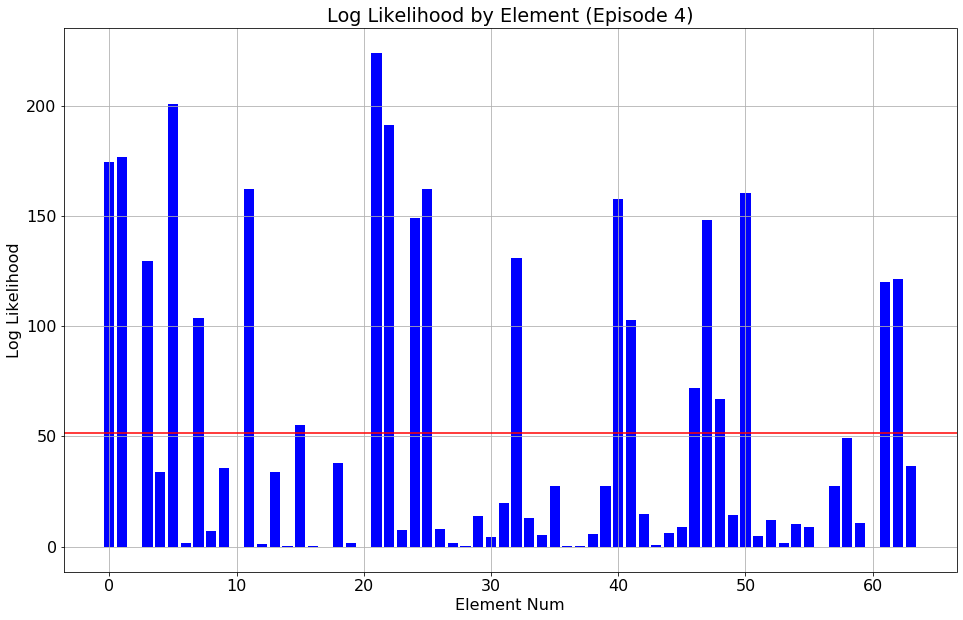

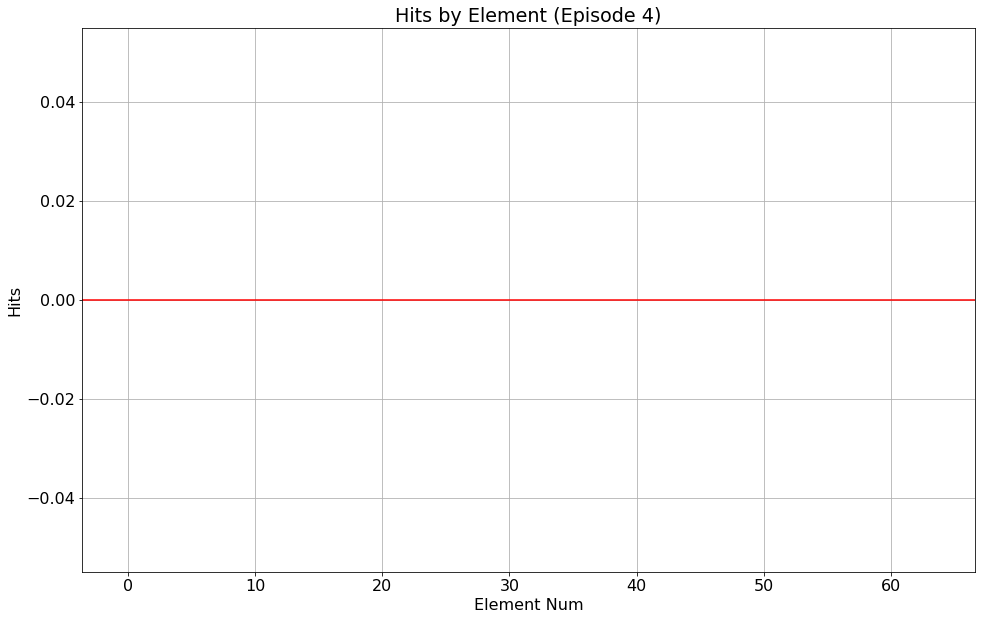


********************************************************************************
Round 2: 5000 batches @ LR 2^-14 with thawed elements.
********************************************************************************
Applying learning_rate 6.10e-05 (2.0^-14.0) for adaptive training.

Training episode 4: Epoch   20, Batch   2000
effective_learning_rate=6.104e-05, training_time 61 sec.
Train on 6400 samples
Epoch 21/25
6400/6400 [==============================] - 5s 820us/sample - loss: -16734740.1400
Epoch 22/25
6400/6400 [==============================] - 3s 508us/sample - loss: -19393805.3000
Epoch 23/25
6400/6400 [==============================] - 3s 512us/sample - loss: -21894726.8800
Epoch 24/25
6400/6400 [==============================] - 3s 513us/sample - loss: -24659317.3600
Epoch 25/25
6400/6400 [==============================] - 3s 505us/sample - loss: -27929310.2800
Geom Mean Resolution:   1064.33 arc seconds
Geom Mean Threshold :   5741.84 arc seconds
Mean Log Likelihood : 

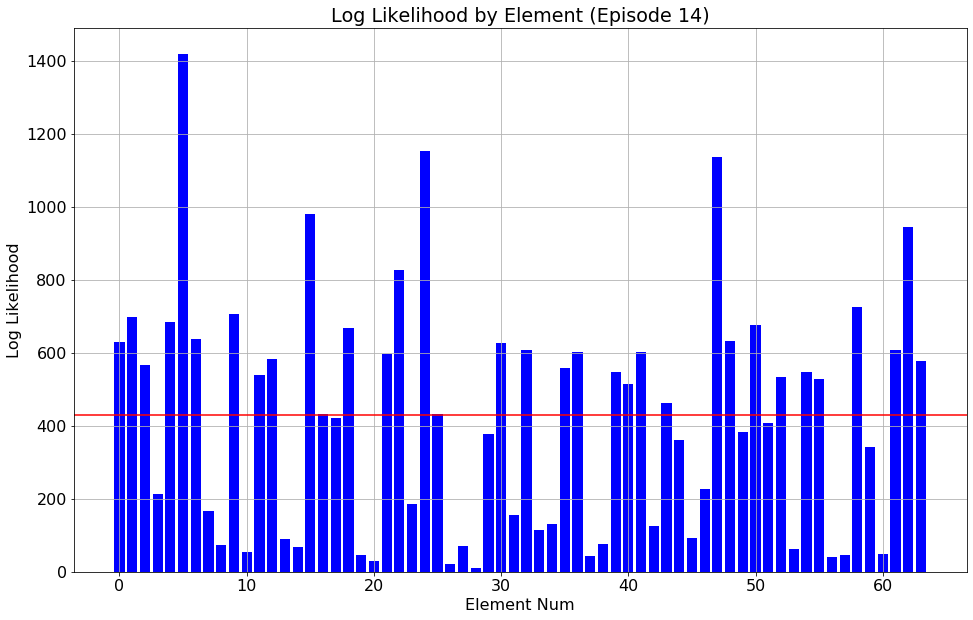

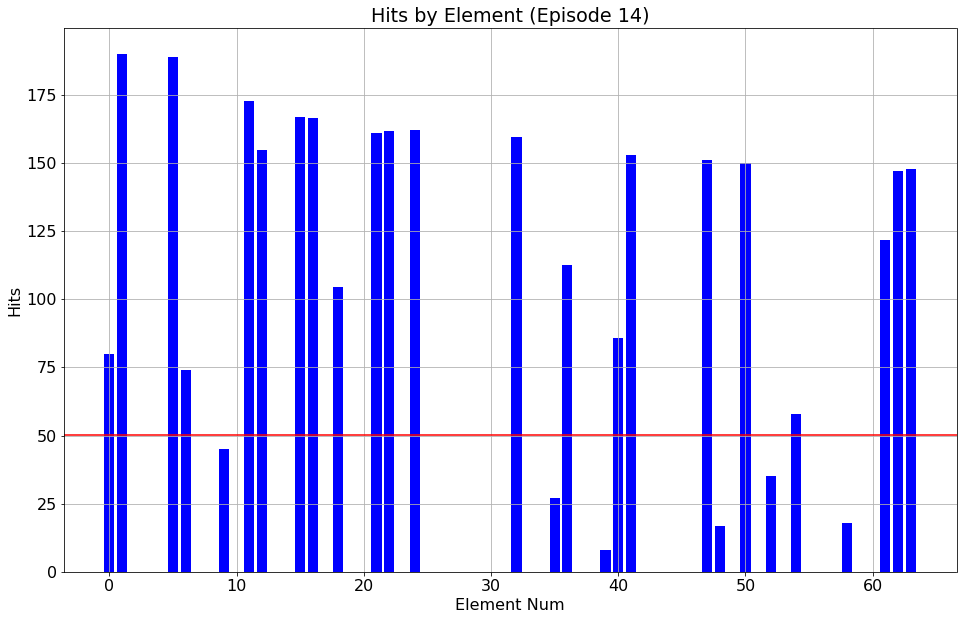


********************************************************************************
Round 3: 1000 batches @ LR 2^-12 with frozen elements.
********************************************************************************

Training episode 14: Epoch   70, Batch   7000
effective_learning_rate=2.750e-05, training_time 247 sec.
Train on 6400 samples
Epoch 71/75
6400/6400 [==============================] - 4s 689us/sample - loss: -4133069240.3200
Epoch 72/75
6400/6400 [==============================] - 3s 457us/sample - loss: -6126804295.6800
Epoch 73/75
6400/6400 [==============================] - 3s 458us/sample - loss: -9629359144.9600
Epoch 74/75
6400/6400 [==============================] - 3s 452us/sample - loss: -16086477701.1200
Epoch 75/75
6400/6400 [==============================] - 3s 458us/sample - loss: -29090231316.4800
Adjusted element weight down on 21 candidate elements. Mean weight = 7.71e-01
Geom Mean Resolution:     92.96 arc seconds
Geom Mean Threshold :   1238.31 arc secon

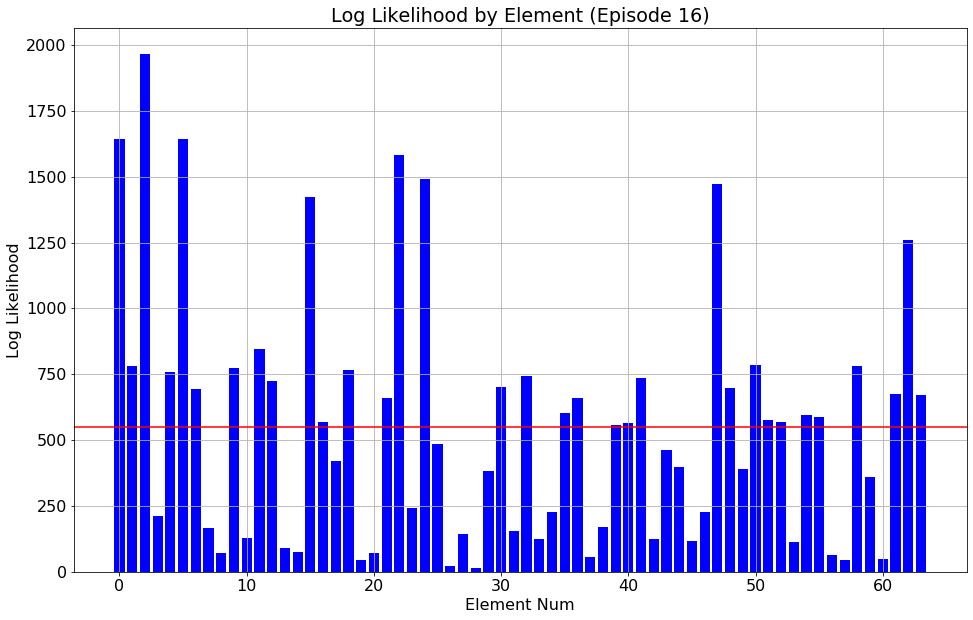

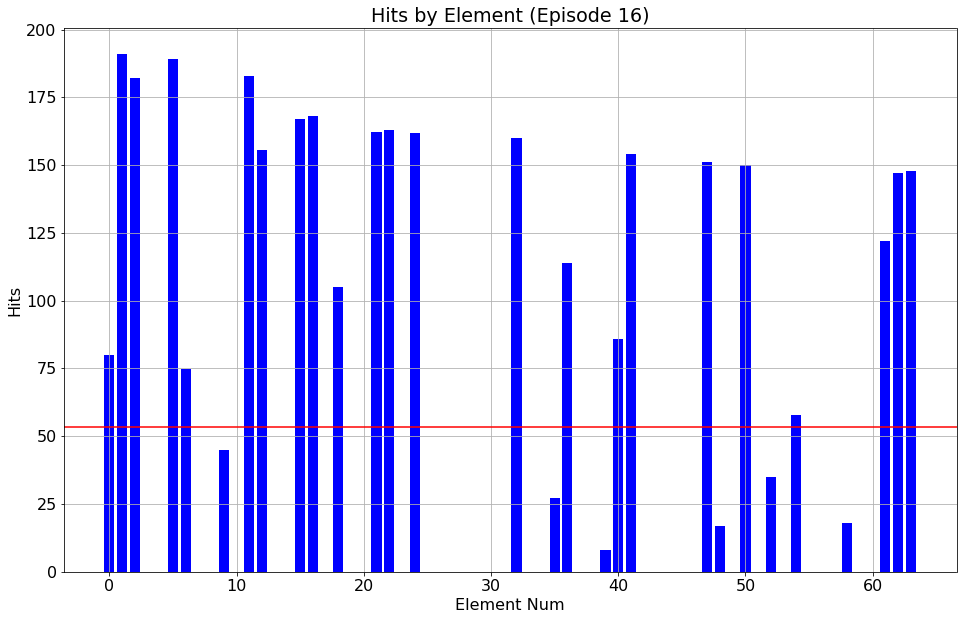


********************************************************************************
Round 4: 5000 batches @ LR 2^-14 with thawed elements.
********************************************************************************
Applying learning_rate 6.10e-05 (2.0^-14.0) for adaptive training.

Training episode 16: Epoch   80, Batch   8000
effective_learning_rate=1.452e-04, training_time 280 sec.
Train on 6400 samples
Epoch 81/85
6400/6400 [==============================] - 6s 869us/sample - loss: -1806438542.8500
Epoch 82/85
6400/6400 [==============================] - 4s 584us/sample - loss: -31851893.0600
Adjusted element weight down on 58 candidate elements. Mean weight = 2.47e-01
Geom Mean Resolution:     76.05 arc seconds
Geom Mean Threshold :   1104.55 arc seconds
Mean Log Likelihood :    552.15
Mean Hits           :     53.55
Good Elements       :     28.00 (with 122.14 hits each)

Training episode 17: Epoch   82, Batch   8200
effective_learning_rate=1.509e-05, training_time 291 sec.
Tra

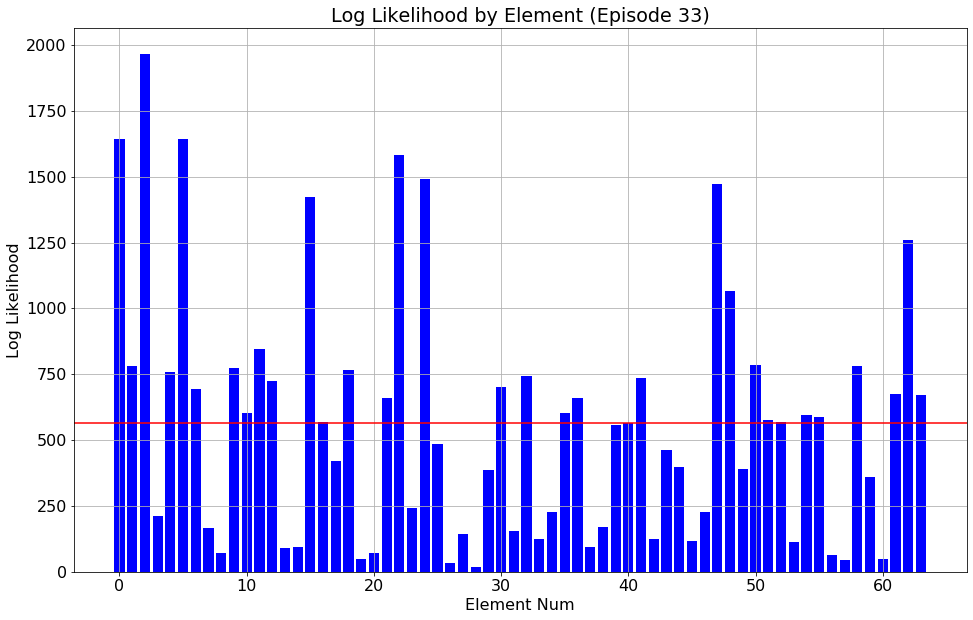

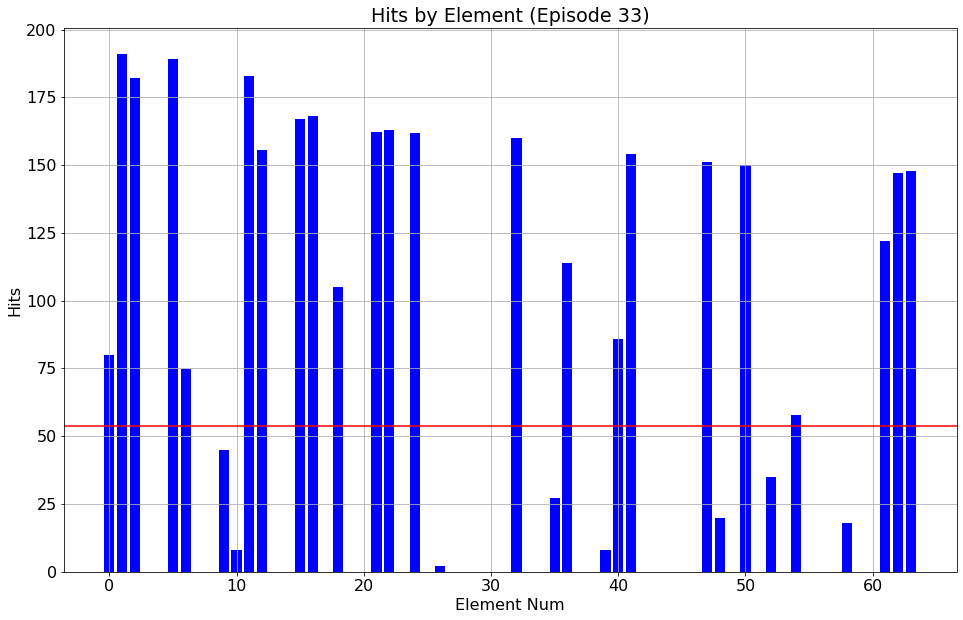


********************************************************************************
Round 3: 1000 batches @ LR 2^-12 with frozen elements.
********************************************************************************

********************************************************************************
Terminating: Effective Learning Rate 5.989e-07 <= minimum 1.907e-06.
********************************************************************************
     \  log_like :  hits  :    R_sec : thresh_sec
Mean   :   564.57  :  53.68 :   516.45 :  3008.90
Median :   566.77  :   0.00 :    42.63 :  1193.59
GeoMean:   356.77  :   7.29 :    76.20 :  1084.32
Std    :   465.14  :  70.53 :   806.28 :  3126.80
Min    :    17.31  :   0.00 :     1.00 :    10.00
Max    :  1965.55  : 190.95 :  2476.48 :  7200.00
Good elements (hits > 10):  28.00
Trained for 11400 batches over 114 epochs and 33 episodes.


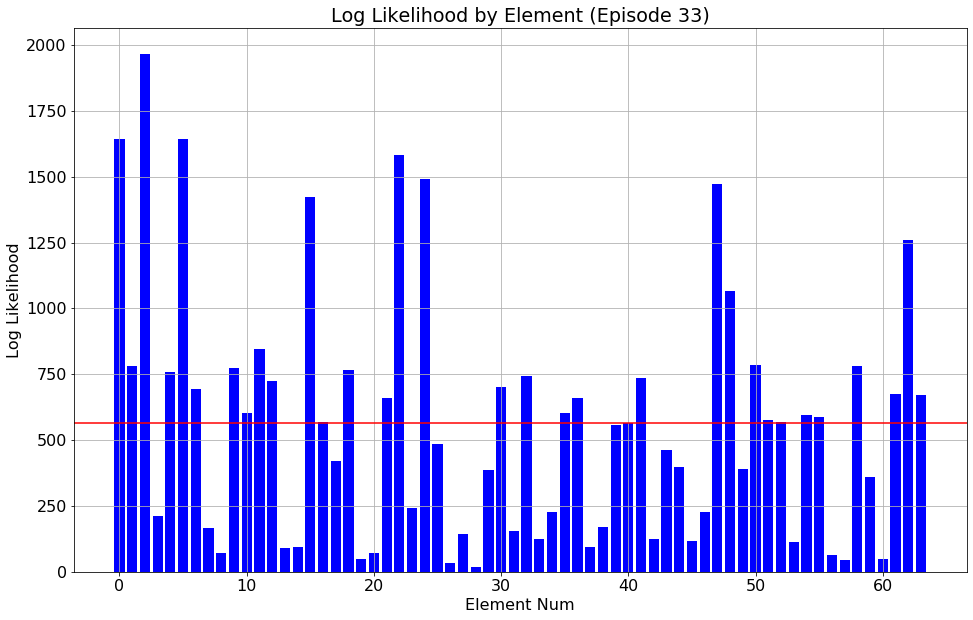

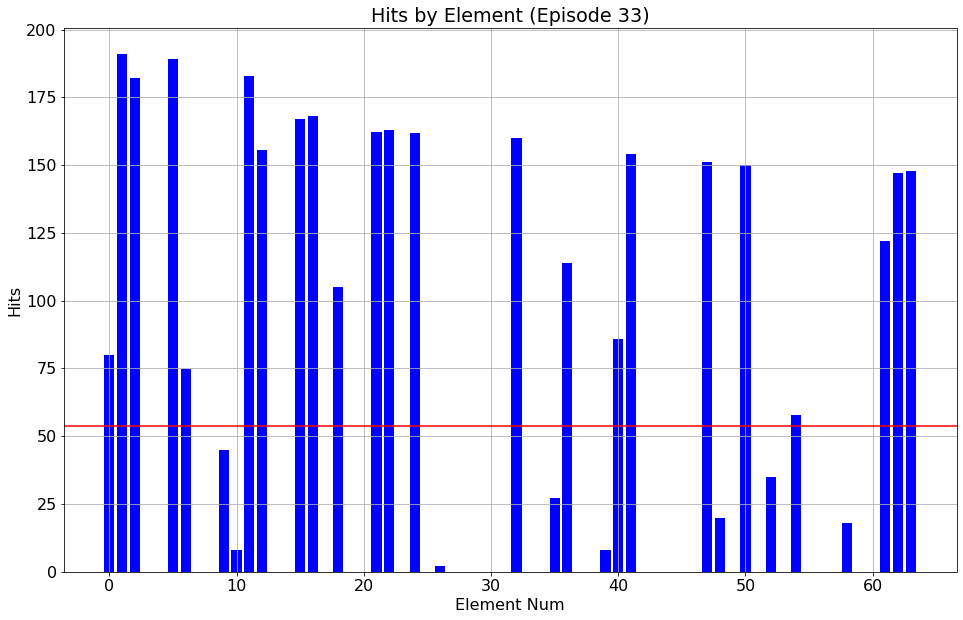

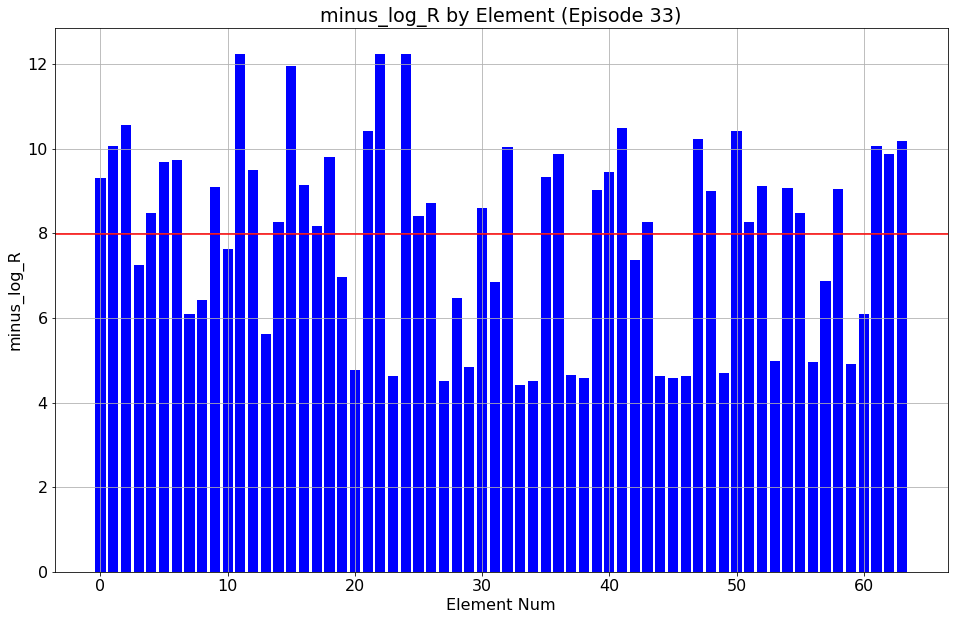

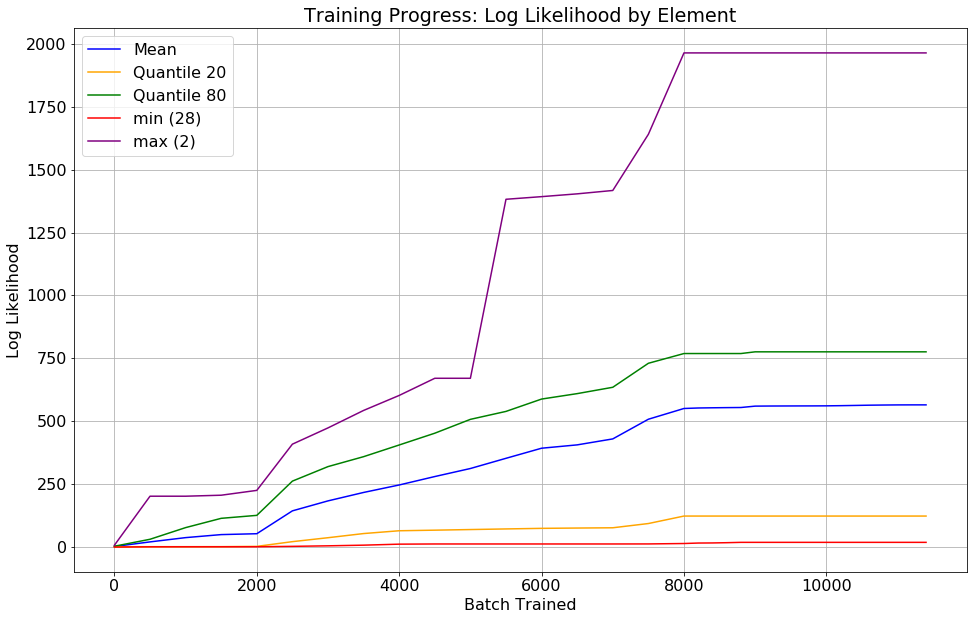

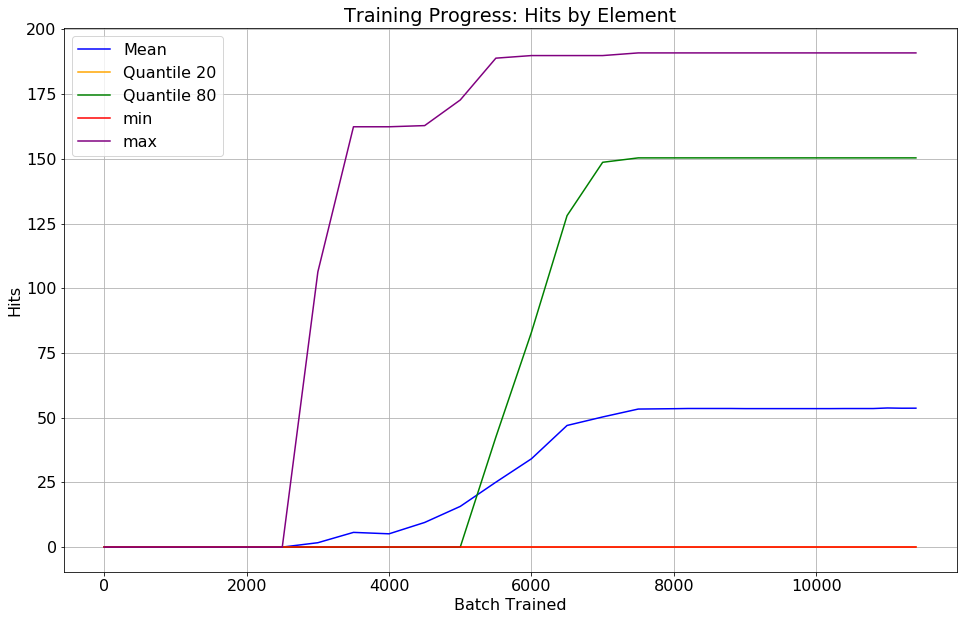

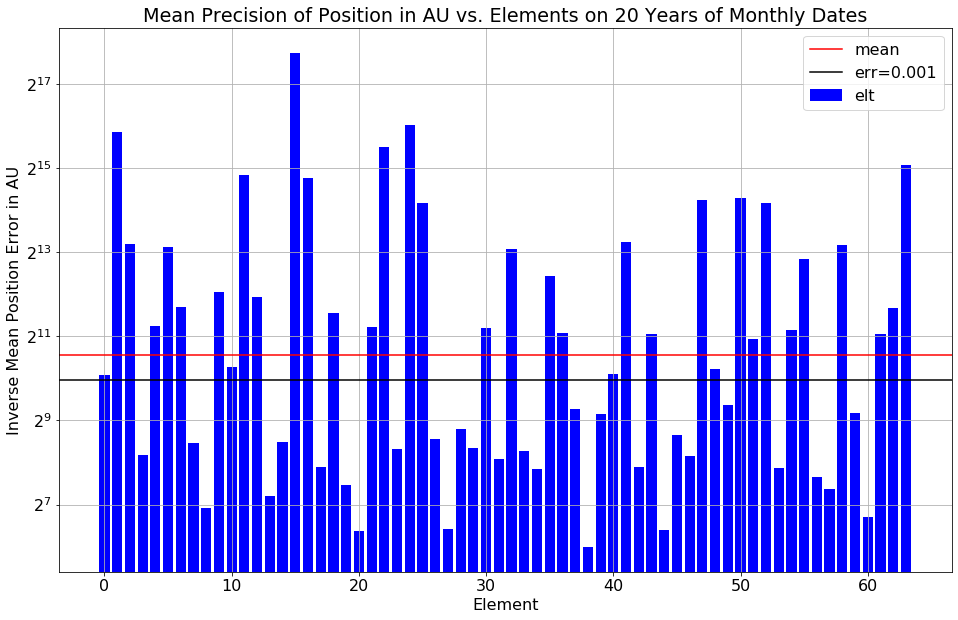

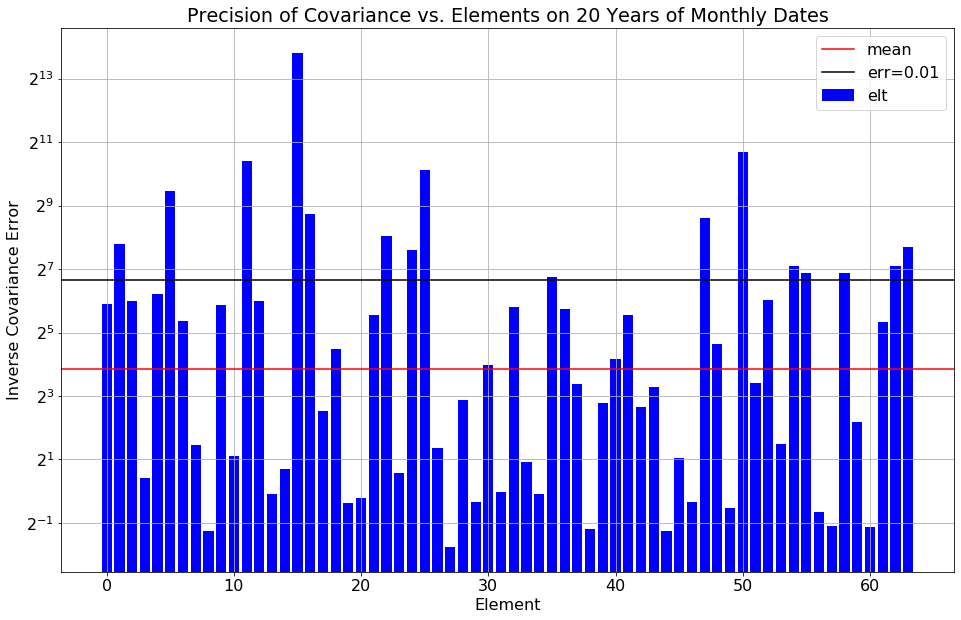

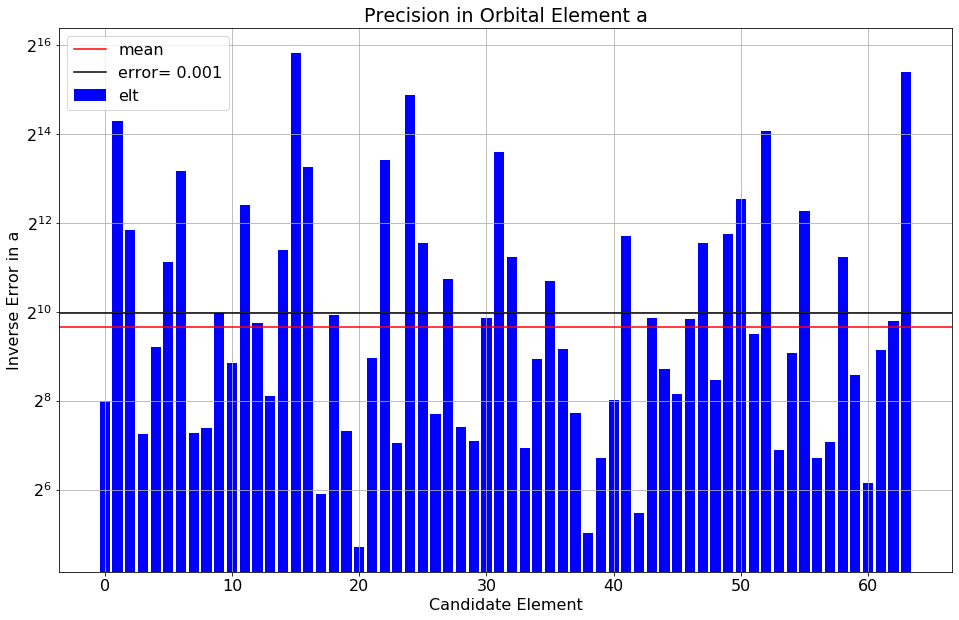

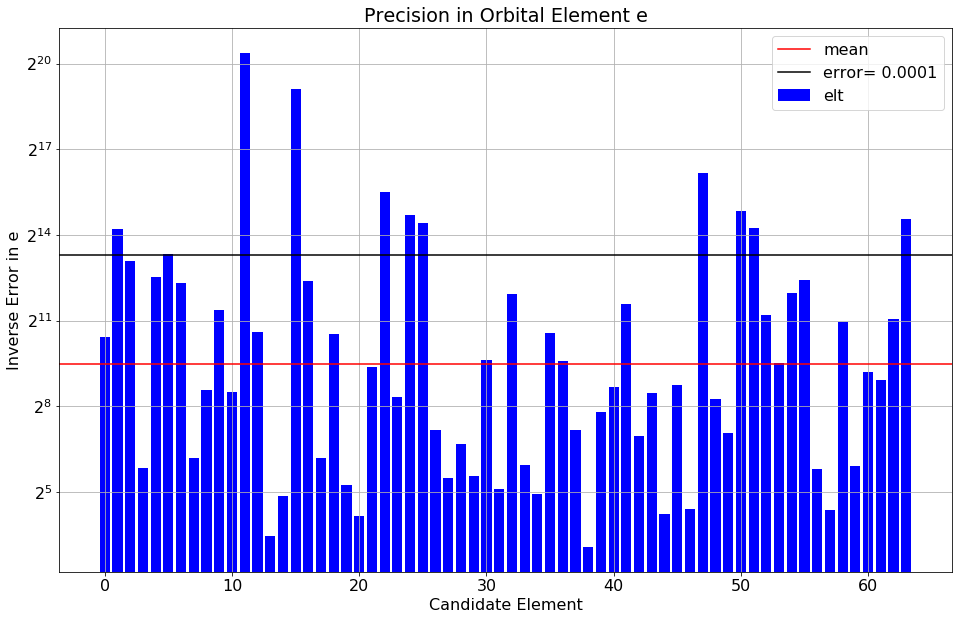

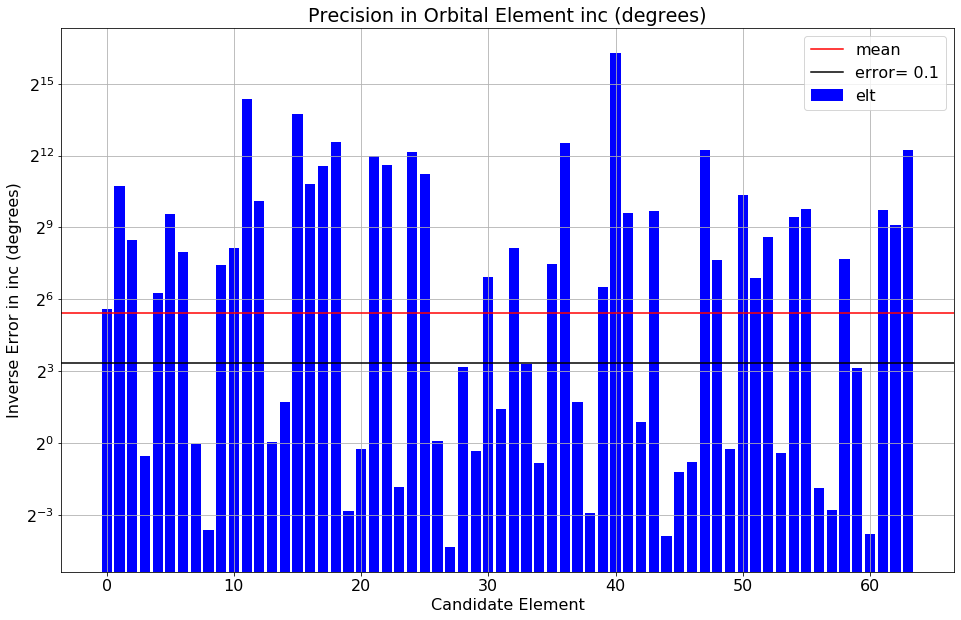

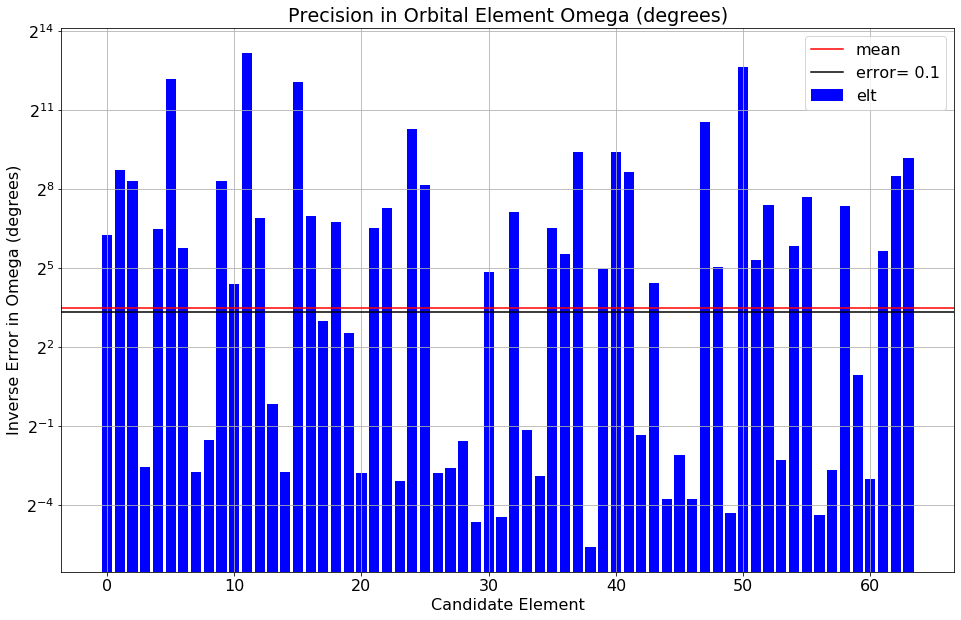

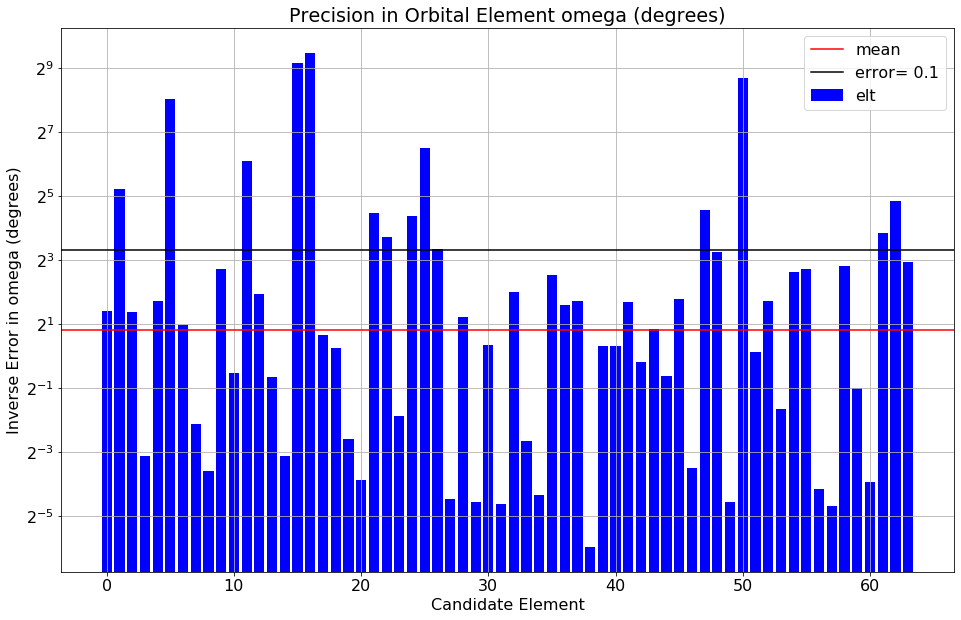

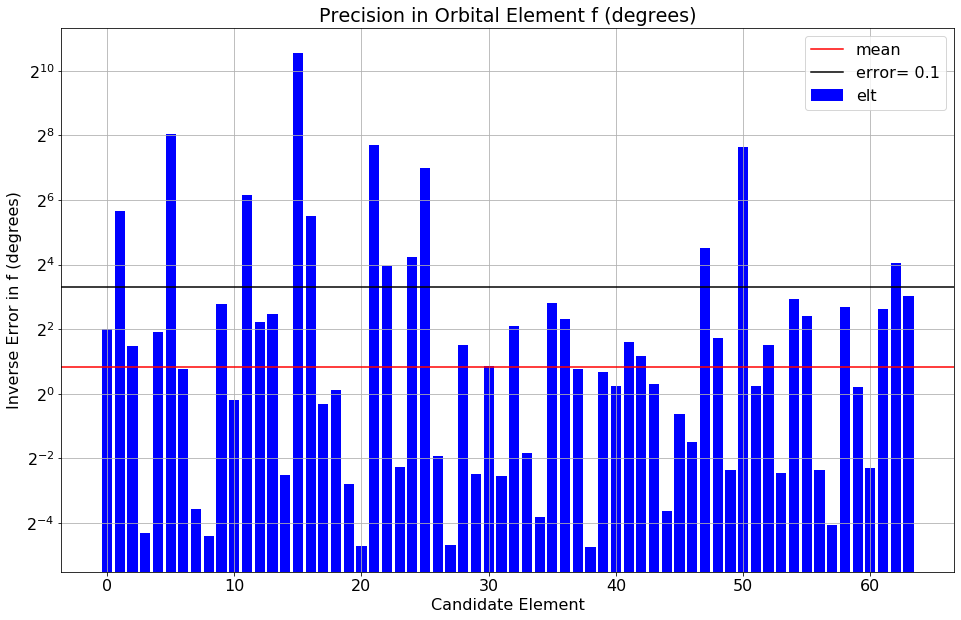

In [32]:
model.sieve()

In [33]:
model.save_state()

## Distance vs. Nearest Asteroid for Fitted Elements

In [34]:
# Find nearest asteroid to fitted elements
elts_fit, elts_near = model.nearest_ast()

In [35]:
# model.save_state()

In [36]:
# Review asteroids nearest to the fitted elements
cols = ['element_id', 'log_like', 'hits', 'R_sec', 'thresh_sec', 'nearest_ast_num', 'nearest_ast_dist', 'nearest_ast_q_norm']

# Summary
has_hits = (model.elts_fit.hits >= 10)
is_converged = has_hits
num_converged = np.sum(is_converged)

# Mean on converged
mean_hits = np.mean(model.elts_fit.hits[is_converged])
err_cart_mean = np.mean(model.elts_near_ast.nearest_ast_dist[is_converged])
err_cart_geo = np.exp(np.mean(np.log(model.elts_near_ast.nearest_ast_dist[is_converged])))
err_cov_mean = np.mean(model.elts_near_ast.nearest_ast_q_norm[is_converged])

# Report
print(f'Good convergence on {num_converged} asteroids.')
print(f'Mean on converged asteroids:')
print(f'Number of hits         : {mean_hits:5.2f}')
# print(f'Mean Distance in AU    : {err_cart_mean:5.2e}')
print(f'GeoMean Distance in AU : {err_cart_geo:5.2e}')
print(f'Covariance norm        : {err_cov_mean:5.2e}')

Good convergence on 28 asteroids.
Mean on converged asteroids:
Number of hits         : 122.05
GeoMean Distance in AU : 1.20e-04
Covariance norm        : 1.46e-02


In [37]:
# Review good matches
model.elts_fit[cols][is_converged].sort_values(by=['hits', 'R_sec'], ascending=[False, True])

,element_id,log_like,hits,R_sec,thresh_sec,nearest_ast_num,nearest_ast_dist,nearest_ast_q_norm
1,59244,780.254395,190.954163,8.859285,102.958855,59244,0.000017,0.004485
5,5817,1641.592896,188.991150,12.738383,2098.970703,5817,0.000112,0.001431
11,9936,847.158691,182.874130,1.000000,9.999999,9936,0.000034,0.000740
2,15786,1965.552612,181.999527,5.284784,7199.998535,15786,0.000107,0.015817
16,48453,567.811462,168.231491,22.051390,157.097473,48453,0.000036,0.002335
15,59245,1422.958618,167.018448,1.334253,191.625534,59245,0.000005,0.000070
22,9229,1583.069824,163.010544,1.000000,173.872162,9229,0.000021,0.003799
21,77774,658.192261,162.276291,6.204595,71.304207,77774,0.000417,0.021143
24,2015,1491.602417,161.999817,1.000000,197.974670,2015,0.000015,0.005202
32,19794,742.340820,159.949951,9.061985,146.577377,19794,0.000116,0.017914


In [38]:
# # Review fitted elements including nearest asteroid
# model.elts_fit

In [39]:
# Add nearest_ast_dist column
model.elts_fit['nearest_ast_dist'] = model.elts_near_ast.nearest_ast_dist
model.elts_fit['nearest_ast_q_norm'] = model.elts_near_ast.nearest_ast_q_norm

# Filter for only the good ones
mask = (model.elts_fit.log_like > 200) & (model.elts_fit.R_sec < 40)
cols = ['element_id', 'num_hits', 'R_sec', 'thresh_sec', 'log_like', 'hits', 'nearest_ast_dist', 'nearest_ast_q_norm']
model.elts_fit[cols][mask].sort_values(by='R_sec')

,element_id,num_hits,R_sec,thresh_sec,log_like,hits,nearest_ast_dist,nearest_ast_q_norm
24,2015,161.779495,1.000000,197.974670,1491.602417,161.999817,0.000015,0.005202
22,9229,253.768158,1.000000,173.872162,1583.069824,163.010544,0.000021,0.003799
11,9936,1023.999939,1.000000,9.999999,847.158691,182.874130,0.000034,0.000740
15,59245,192.615997,1.334253,191.625534,1422.958618,167.018448,0.000005,0.000070
2,15786,354.537872,5.284784,7199.998535,1965.552612,181.999527,0.000107,0.015817
41,3426,263.543121,5.678503,80.212624,736.208008,153.951370,0.000103,0.021228
50,6455,149.970551,6.115103,124.256554,785.047485,149.989914,0.000050,0.000602
21,77774,234.167969,6.204595,71.304207,658.192261,162.276291,0.000417,0.021143
47,733,150.970673,7.479406,2039.327271,1472.234863,150.997681,0.000052,0.002558
63,72911,147.989426,7.848612,110.279945,671.928894,147.989578,0.000029,0.004855


In [40]:
# # Filter for incomplete convergence
# mask = (elts_fit.log_like > 200) & (elts_fit.R_sec >= 60)
# elts_fit[mask]

## Visualize Error vs. Nearest Asteroid

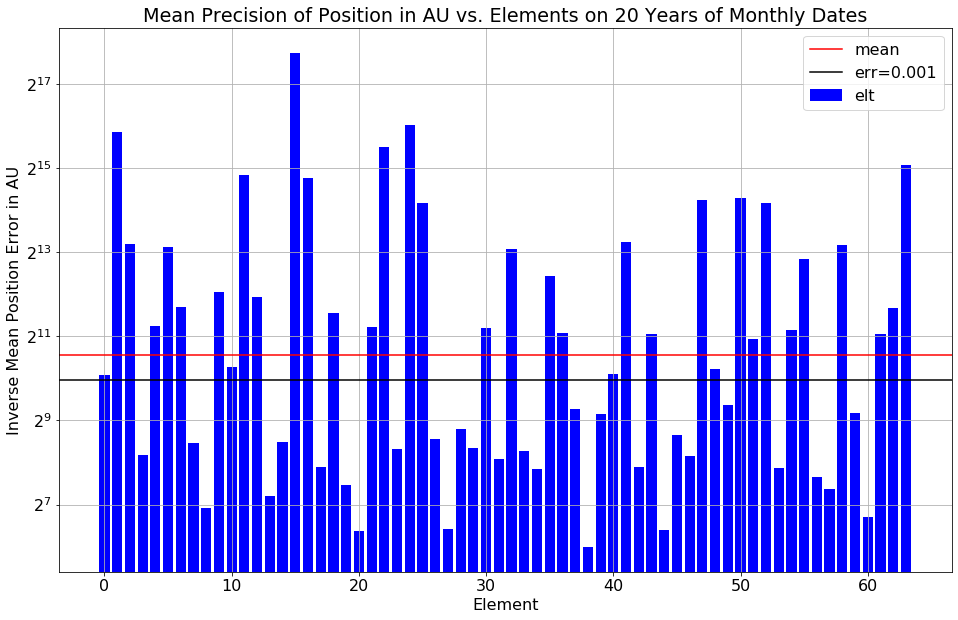

In [41]:
# Plot position error vs. known elements
fig, ax = model.plot_q_error(plot_type='cart', is_log=True, use_near_ast_dist=True)

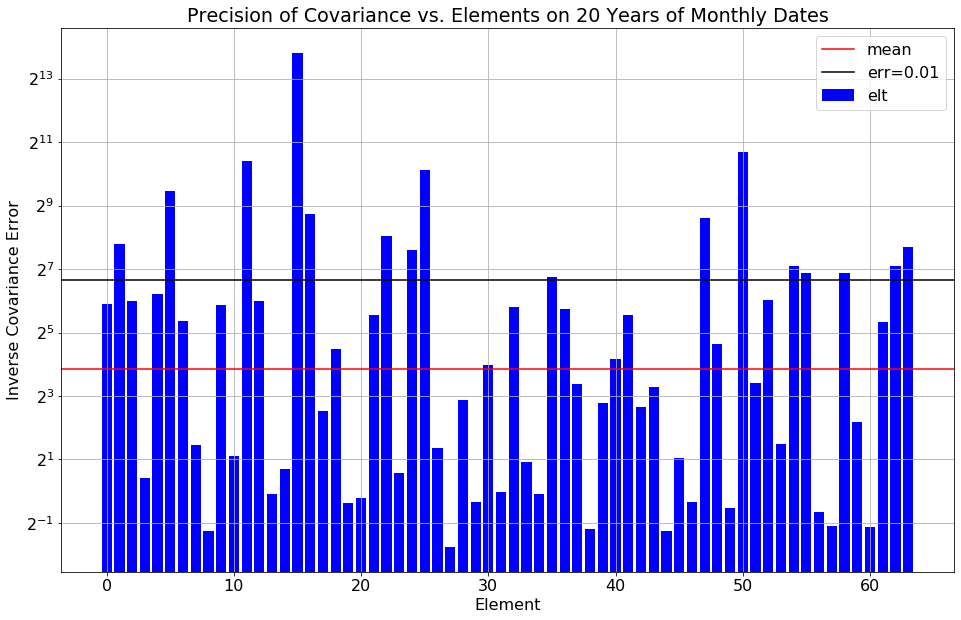

In [42]:
# Plot position error vs. known elements
fig, ax = model.plot_q_error(plot_type='cov', is_log=True, use_near_ast_dist=True)

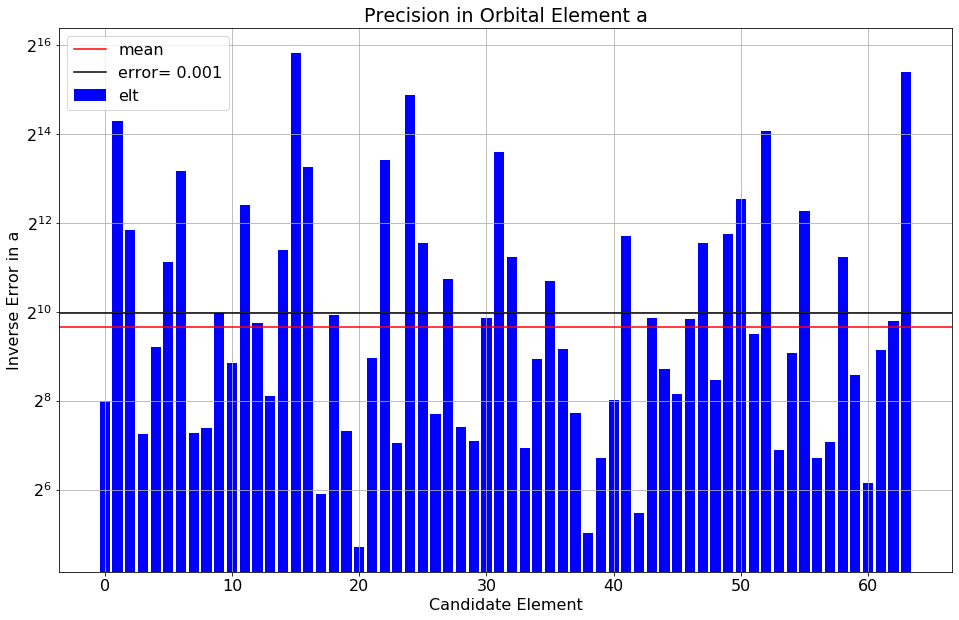

In [43]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='a', is_log=True)

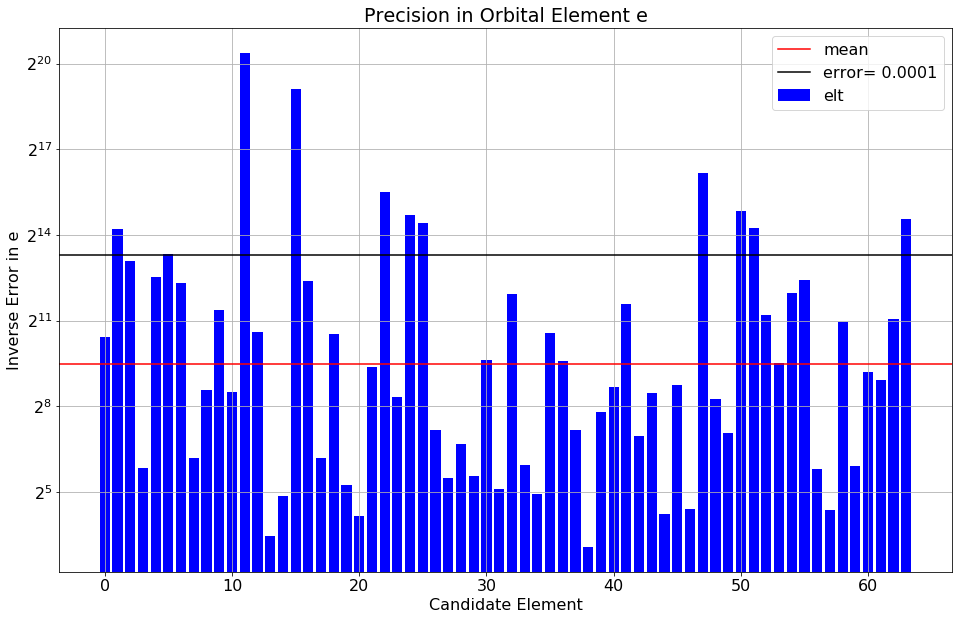

In [44]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='e', is_log=True)

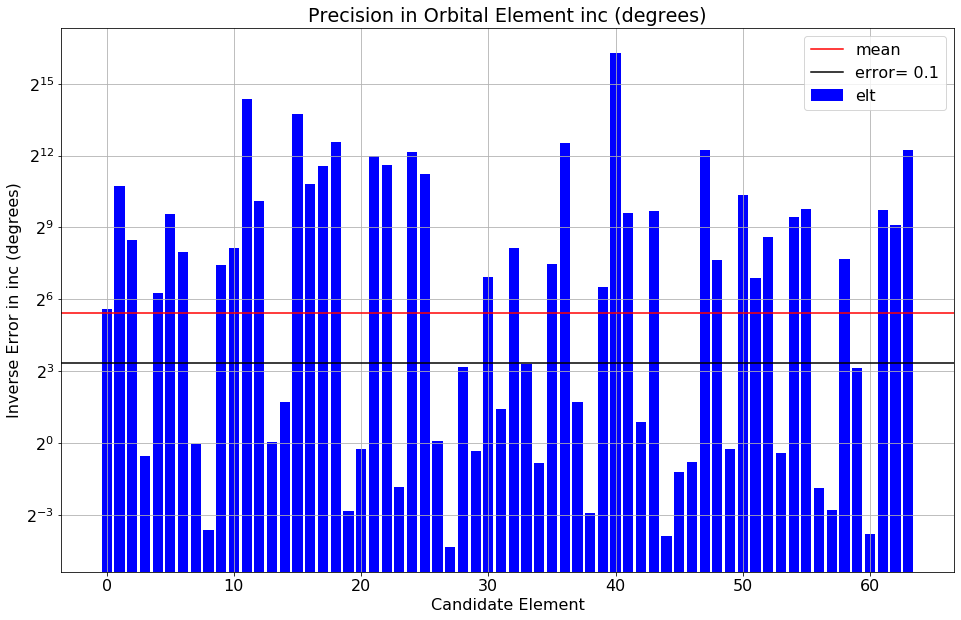

In [45]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='inc', is_log=True)

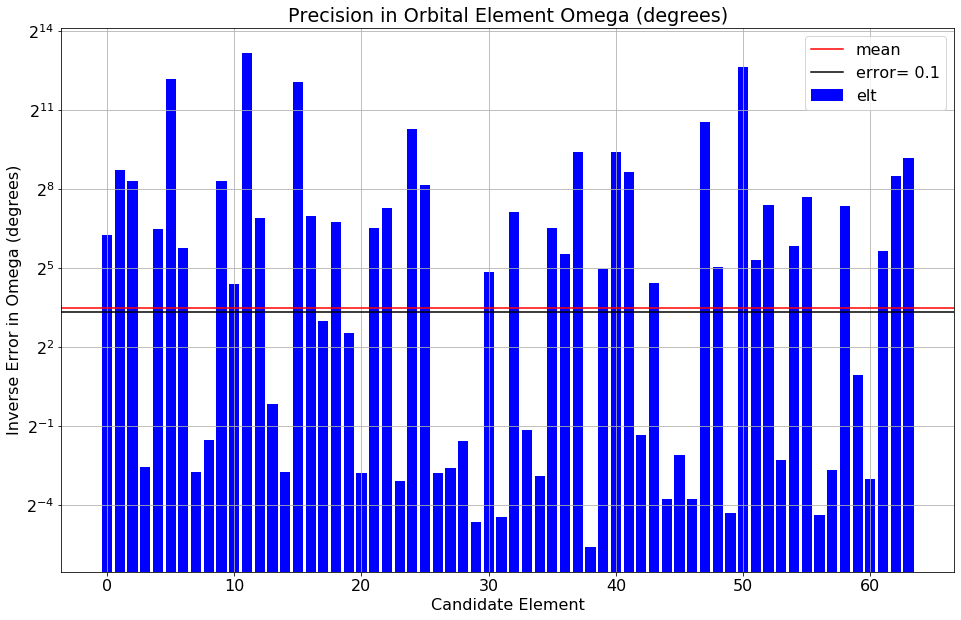

In [46]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='Omega', is_log=True)

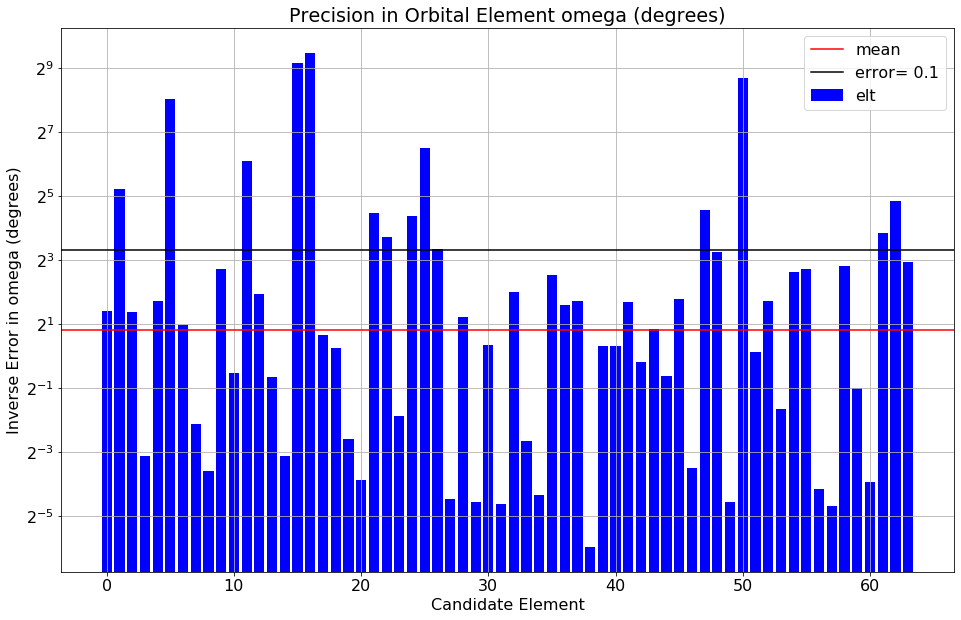

In [47]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='omega', is_log=True)

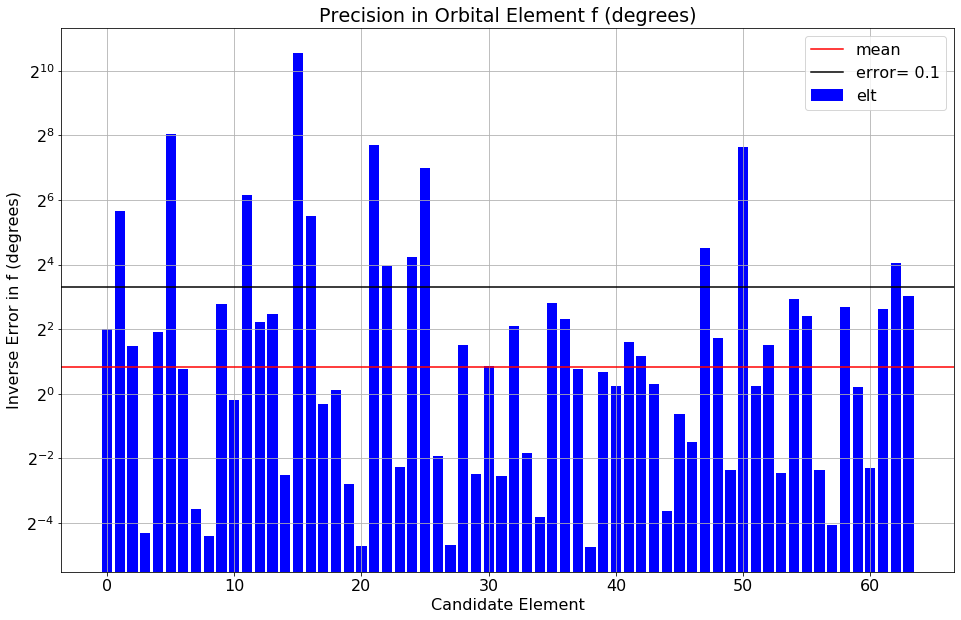

In [48]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='f', is_log=True)